# แปลง Polar to Cartesian ในพิกัดภูมิศาสตร์
* เลือกมุมยก
* สร้างกริด
* เซฟเป็น geotife

In [1]:
'''
2024/01/09 
พัฒนาโค้ดโดย รศ.ดร.นัฐพล มหาวิค 
email:nattaponm@nu.ac.th 
ยูทูป:https://www.youtube.com/@Nattapon_Mahavik/playlists 
หนังสือ: เรดาร์ตรวจอากาศทางอุตุนิยมวิทยา https://www.chulabook.com/education/144567
Github: https://github.com/nattaponm
Scopus: https://www.scopus.com/authid/detail.uri?authorId=55583236600
'''

'\n2024/01/09 \nพัฒนาโค้ดโดย รศ.ดร.นัฐพล มหาวิค \nemail:nattaponm@nu.ac.th \nยูทูป:https://www.youtube.com/@Nattapon_Mahavik/playlists \nหนังสือ: เรดาร์ตรวจอากาศทางอุตุนิยมวิทยา https://www.chulabook.com/education/144567\nGithub: https://github.com/nattaponm\nScopus: https://www.scopus.com/authid/detail.uri?authorId=55583236600\n'

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import pyart
#import sys


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [3]:
print (pyart.__version__)

1.12.5


In [4]:
file = "../1data/0radar/1radar_tmd/PHS240@201807201000.uf.bz2"
radar = pyart.io.read(file)
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio'])


# หาค่า signal to noise ratio  แล้วแอดฟิวด์

In [5]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar, refl_field='reflectivity',toa=15000.0) #15000 ทดลองเอง
radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)

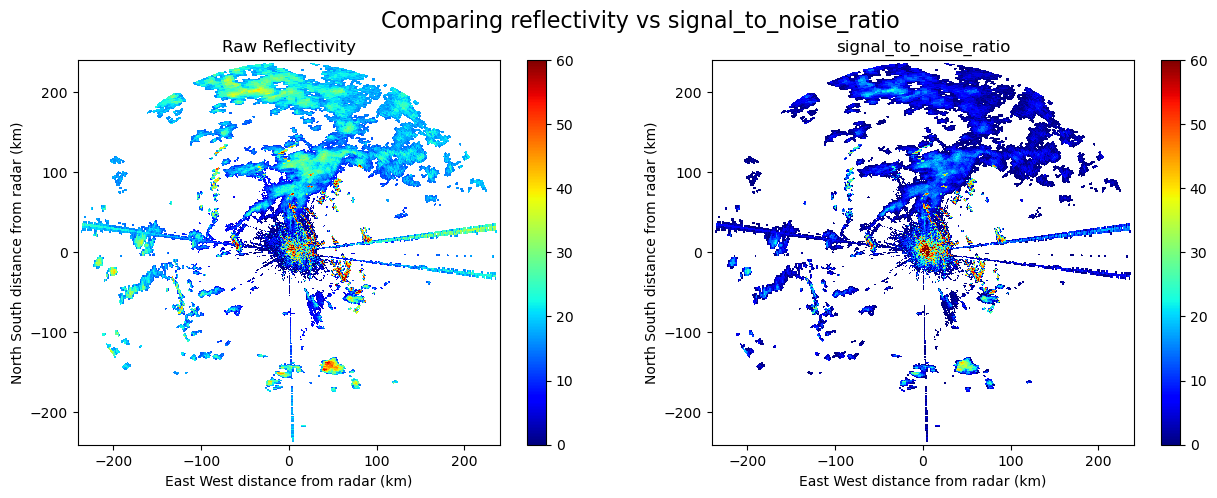

In [6]:
# create the plot
fig = pl.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
display = pyart.graph.RadarDisplay(radar)
#display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=60., 
display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet',
                 title='Raw Reflectivity')
                 #title='Raw Reflectivity')

ax2 = fig.add_subplot(122)
display.plot_ppi('signal_to_noise_ratio', 0, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet', ax=ax2,
                 title='signal_to_noise_ratio')

pl.suptitle('Comparing reflectivity vs signal_to_noise_ratio', fontsize=16)
pl.show()

# กรองสัญญาณรบกวน ด้วยการใช้ SNR ใช้ gatefilter

In [7]:
gtfilter = pyart.filters.moment_and_texture_based_gate_filter(radar, phi_field='differential_phase')
gtfilter.exclude_below('signal_to_noise_ratio', 5) #ใช้ค่า snr  = 10 
#gtfilter.exclude_above('signal_to_noise_ratio', 70) #ใช้ค่า snr  = 60 

In [8]:
# แอดฟิวด์ที่ได้กรองสัญญาณรบกวนออกไป เอาโค้ดมาจาก  https://github.com/ARM-DOE/pyart/issues/763
radar.add_field_like('reflectivity', 'reflectivity_copy',
                     radar.fields['reflectivity']['data'].copy())
nf = radar.fields['reflectivity_copy']
nf['data'] = np.ma.masked_where(gtfilter.gate_excluded , nf['data'])
radar.add_field('filtered_reflectivity', nf, replace_existing=True)
print(radar.fields.keys())

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'signal_to_noise_ratio', 'reflectivity_copy', 'filtered_reflectivity'])


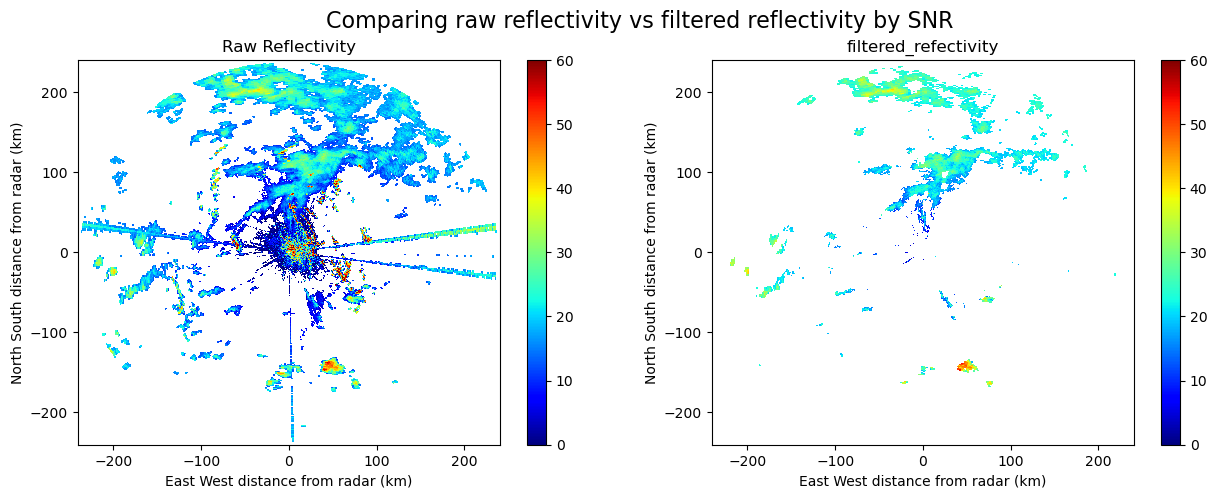

In [9]:
# create the plot
fig = pl.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
display = pyart.graph.RadarDisplay(radar)
#display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=60., 
display.plot_ppi('reflectivity', 0, ax=ax1, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet',
                 title='Raw Reflectivity')
                 #title='Raw Reflectivity')

ax2 = fig.add_subplot(122)
display.plot_ppi('filtered_reflectivity', 0, vmin=0, vmax=60., 
                 colorbar_label='', cmap='jet', ax=ax2,
                 title='filtered_refectivity')

pl.suptitle('Comparing raw reflectivity vs filtered reflectivity by SNR', fontsize=16)
pl.show()

# Gridding PPI to cartesian

In [10]:
radar_p=radar.extract_sweeps([0]) # เลือกมุมยก 0 คือ มุมแรก
lat_0 = radar_p.latitude['data'][0]
lon_0 = radar_p.longitude['data'][0]

shape = (1, 241, 241)
grid = pyart.map.grid_from_radars(
            radar_p,
            grid_shape=shape, #Number of points in the grid (z, y, x)
            grid_limits=((2000, 2000), (-240000, 240000), (-240000, 240000)),    # ตั้งค่า(2000, 2000) หมายความว่าต้องการให้สร้างกริด cappi ที่ระดับ 2 km จาก ppi ดังกล่าว
            grid_origin = (lat_0,lon_0),
            fields=['filtered_reflectivity'],
            roi_func= 'constant', constant_roi=4000.0 # เปลี่ยนฟังก์ชั่นเป็น roi_func= 'constant' เพื่อต้องการให้ดึงขัอมูลจุดของมุม ppi ที่อยู่ในระดับสูงมาคิดน้ำหนักด้วย สังเกตตรงกลางสถานีจะมีค่าฝนแล้ว
)

### ให้พลอตเทียบทั้้งใน pyart และ qgis
* ทดลองเปลี่ยนมุมยยก radar.extract_sweeps([1]) หรือ 2,3     
* ทดสอบระดับความสูงอื่นๆ grid_limits=((3000, 3000)... เป็น 4,5,6

                               

C:\Users\User\miniconda3\envs\ml_dl_n1\lib\site-packages\pyart\graph\gridmapdisplay.py:213: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Mercator.
  warnings.warn(


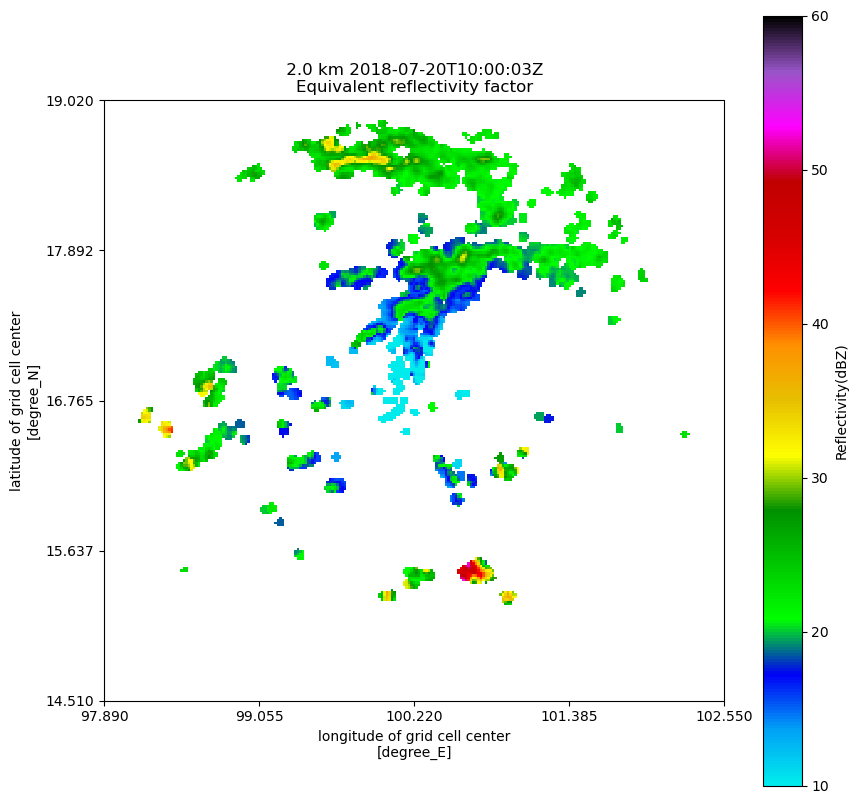

In [11]:
fig = pl.figure(figsize=[10, 10])
display = pyart.graph.GridMapDisplay(grid)
display.plot_grid("filtered_reflectivity", level=0, cmap=pyart.graph.cm.NWSRef, vmin=10, vmax=60)

# ส่งออกผลลัพธ์ PPI ไปเป็น geotiff นำไปใช้ใน qgis

In [12]:
pyart.io.write_grid_geotiff(grid, '../2results/filtered_dbz_PPI1_phs.tif', 'filtered_reflectivity', rgb=False, level=0, warp=True, sld=False, use_doublequotes=True)

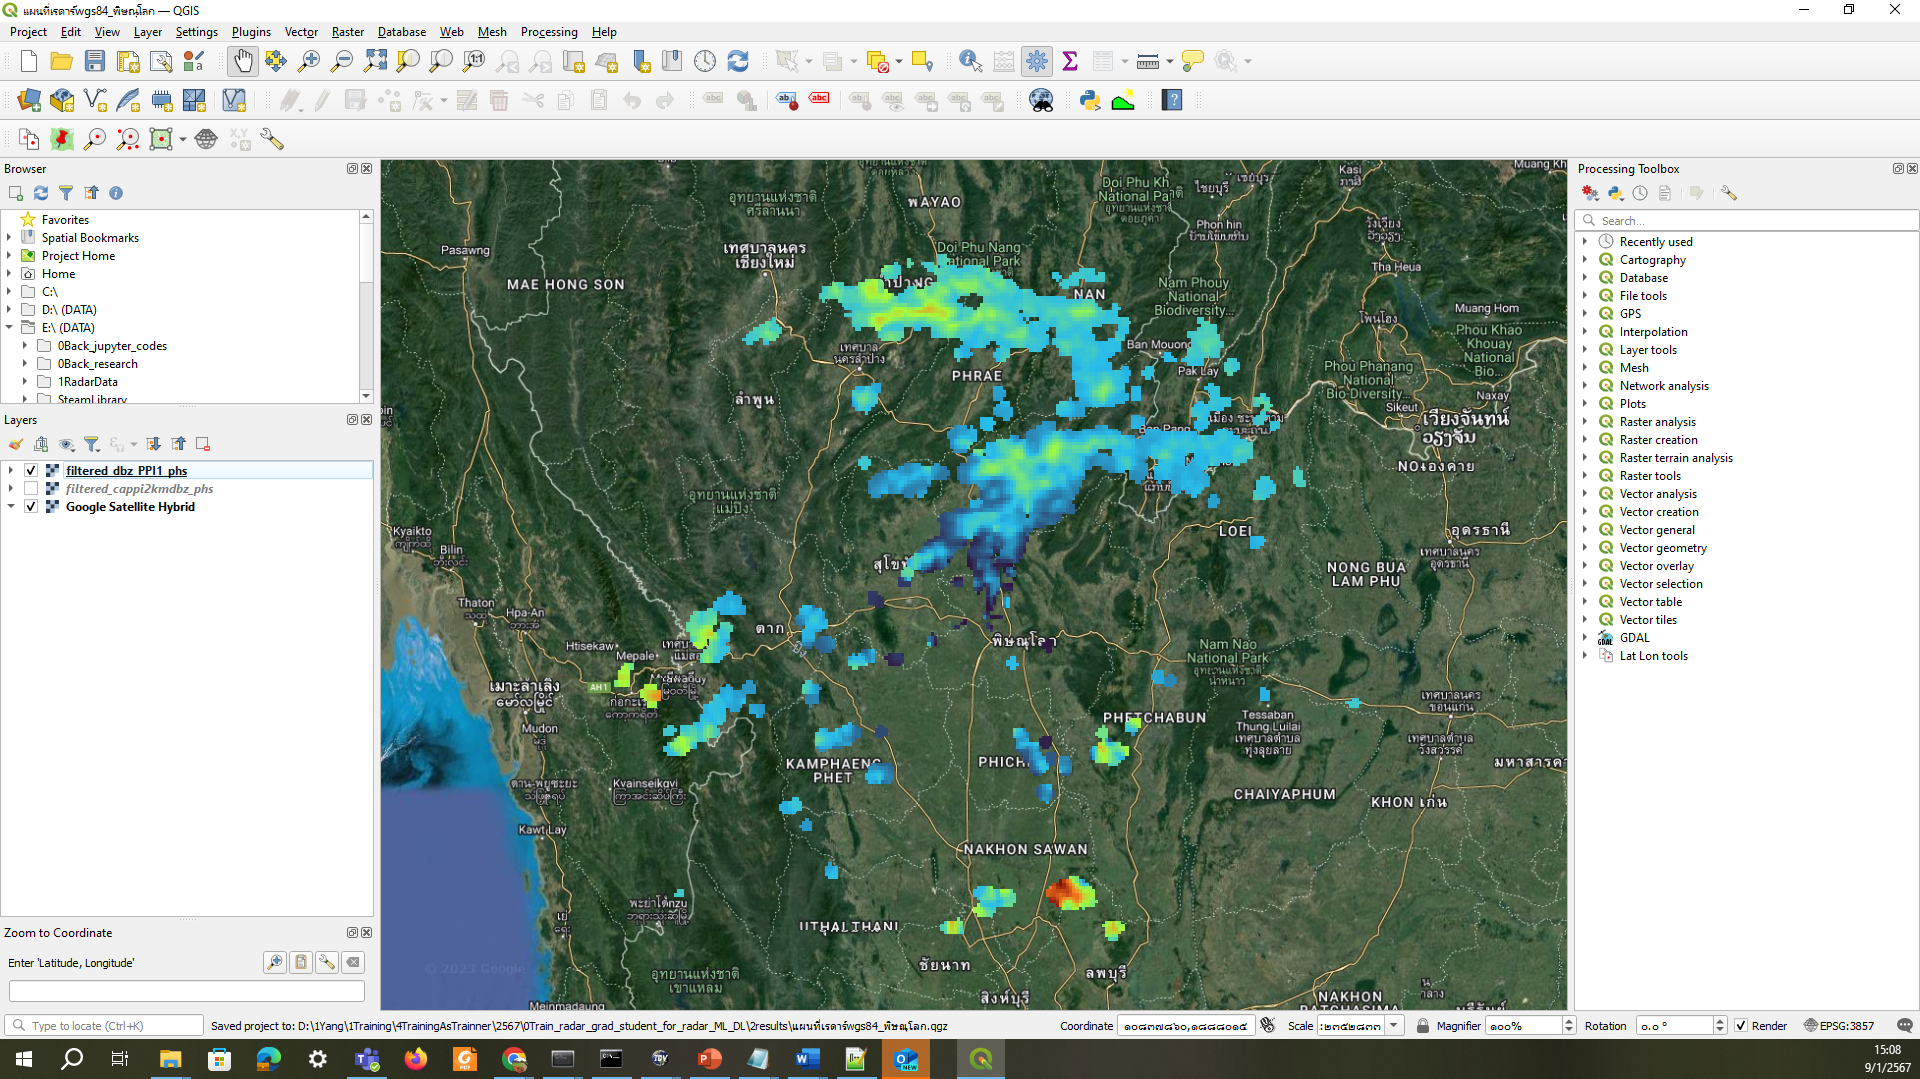